In [119]:
%matplotlib inline 

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from utils import processed, load, denormalize, get_normalized_adj, generate_dataset

In [120]:
class Temporal_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(Temporal_Layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel))
        
    def forward(self, x):
        x = x.permute(0,3,1,2).type(torch.cuda.FloatTensor)
        normal = self.conv1(x)
        sig = torch.sigmoid(self.conv2(x))
        out = normal * sig
        out = out.permute(0,2,3,1)
        # Convert back from NCHW to NHWC
        return out
        
        
class Stgcn_Block(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, nodes_num):
        super(Stgcn_Block, self).__init__()
        self.temporal_layer1 = Temporal_Layer(in_channels, out_channels, kernel = 2) 
        self.temporal_layer2 = Temporal_Layer(in_channels = spatial_channels, out_channels = out_channels, kernel = 2)
        
        self.weight = nn.Parameter(torch.FloatTensor(out_channels, spatial_channels)) 
        self.initialise_weight()
        
        self.batch_norm = nn.BatchNorm2d(nodes_num)
        
        
    def initialise_weight(self):
        std_dv = 1. / math.sqrt(self.weight.shape[1])
        self.weight.data.uniform_(-std_dv, std_dv)
        
    def forward(self, x, adj_hat):
        # First temporal Block
        temporal_block1 = self.temporal_layer1(x)
        
        #Spatial Graph Convolution
        t = temporal_block1.permute(1,0,2,3) #Converts tensor from nhwc to hnwc for multiplication with adj_matrix
        t = t.type(torch.cuda.DoubleTensor)
        gconv1 = torch.einsum("ij, jklm -> kilm", [adj_hat, t]) #(h,h) * (h,n,w,c) -> (n,h,w,c)
        gconv2 = F.relu(torch.matmul(gconv1, self.weight.double()))
        
        #Second Temporal Block
        temporal_block2 = self.temporal_layer2(gconv2) 
        
        out = self.batch_norm(temporal_block2)
        return out

class Stgcn_Model(nn.Module):
    def __init__(self, nodes_num, features_num, input_timesteps, num_output):
        super(Stgcn_Model, self).__init__()
        self.stgcn_block1 = Stgcn_Block(in_channels = features_num, spatial_channels = 16, out_channels = 64,
                                       nodes_num = nodes_num)
        
        self.stgcn_block2 = Stgcn_Block(in_channels = 64, spatial_channels = 16,  out_channels = 64,
                                       nodes_num = nodes_num)
        
        self.temporal_layer = Temporal_Layer(in_channels = 64, out_channels = 64, kernel = 2)
        self.fc = nn.Conv2d(64, num_output, kernel_size = (1,1))

    def forward(self, adj_hat, x):
        out1 = self.stgcn_block1(x, adj_hat)
        out2 = self.stgcn_block2(out1, adj_hat)
        out3 = self.temporal_layer(out2) #out3.shape = 12,53,1,64
        #reshaped to torch.Size([12, 64, 53, 1]) of format batchsize, in_channels, height (num_nodes), width to match pytorch conv2d input
        out3_temp = out3.reshape((out3.shape[0], out3.shape[3], out3.shape[1], out3.shape[2]))
        out4 = self.fc(out3_temp) #out4.shape = 12,2,53,1 where 2 = num_output
        out5 = torch.squeeze(out4) #Remove the last dimension of size 1
        out6 = out5.reshape((out5.shape[0], out5.shape[2], out5.shape[1])) #Reshape into 12,53,2 to match our y target shape
        return out6

In [121]:
def train(x_input, x_target, batch_size):
    num_samples = x_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    
    training_loss = []
    for i in range(math.ceil(num_samples / batch_size)):
        stgcn.train()
        optimizer.zero_grad()
        
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        x_batch = x_input[batch].to(device = device)
        y_batch = x_target[batch].to(device = device)
        
        
        out = stgcn(adj_mat, x_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.detach().cpu().numpy())
        
    return sum(training_loss) / len(training_loss)

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
batch_size = 12

num_timesteps_input = 6 # 30 minutes
num_timesteps_output = 2 # 10 minutes

In [123]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, means, stds = load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [124]:
def validate(val_input, val_target, batch_size):
    num_samples = val_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    total_val_loss = 0
    counter = 0
    for i in range(math.ceil(num_samples / batch_size)):
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        val_input_batch = val_input[batch].to(device = device)
        val_target_batch = val_target[batch].to(device = device)
        out = stgcn(adj_mat, val_input_batch)
        val_loss = loss_criterion(out, val_target_batch).to(device='cpu')
        total_val_loss += val_loss
        counter += 1
        
    total_val_loss = total_val_loss / counter
    return total_val_loss
    
    
    

In [125]:
def predict(x_input):
    num_samples = x_input.shape[0]
    results = []
    for i in range(math.ceil(num_samples/batch_size)):
        start = i * batch_size
        test_input = x_input[start: start+batch_size]
        if test_input.shape[0] % batch_size != 0:
            continue
        with torch.no_grad():
            stgcn.eval()
            out = stgcn(adj_mat, test_input)
            results.append(out)
    return results
    

In [126]:
stgcn = Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output).to(device = device)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = 0.01)
loss_criterion = nn.MSELoss()

training_loss = []
validation_loss = []

for epoch in range(epochs):
    loss = train(training_input, training_target, batch_size)
    training_loss.append(loss)

    with torch.no_grad():
        stgcn.eval()
        val_loss = validate(val_input, val_target, batch_size)
        validation_loss.append(val_loss.item())

    print("Training Loss: {}".format(loss))
    print("Validation Loss: {}".format(val_loss))




Training Loss: 0.6411542870941009
Validation Loss: 0.5401932597160339
Training Loss: 0.5682176280627276
Validation Loss: 0.5079070925712585
Training Loss: 0.5474164063599021
Validation Loss: 0.4949322044849396
Training Loss: 0.532769089235979
Validation Loss: 0.5004828572273254
Training Loss: 0.526728510776943
Validation Loss: 0.5228110551834106
Training Loss: 0.5236492490864055
Validation Loss: 0.4776964783668518
Training Loss: 0.5228814606201202
Validation Loss: 0.47979289293289185
Training Loss: 0.5160404213450172
Validation Loss: 0.476421058177948
Training Loss: 0.5139721892973318
Validation Loss: 0.47891145944595337
Training Loss: 0.5147026827469229
Validation Loss: 0.5118734836578369
Training Loss: 0.5143967595967379
Validation Loss: 0.48229578137397766
Training Loss: 0.511115378794823
Validation Loss: 0.475333034992218
Training Loss: 0.5074060172798799
Validation Loss: 0.47046563029289246
Training Loss: 0.5063417321220439
Validation Loss: 0.46690434217453003
Training Loss: 0.506

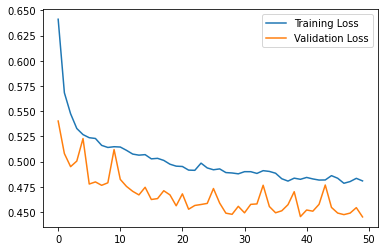

In [127]:

plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [128]:
with torch.no_grad():
    stgcn.eval()
    test_loss = validate(test_input, test_target, batch_size)
    print(test_loss)

tensor(0.4164)


In [129]:
results = predict(test_input)

In [130]:
print(denormalize(results, stds[0], means[0]))

[[[tensor([[[3.1296, 3.0797],
         [3.2678, 3.2933],
         [3.7836, 3.8841],
         ...,
         [4.0393, 4.2203],
         [2.9699, 2.8970],
         [4.2133, 4.1713]],

        [[3.2434, 3.2398],
         [3.4789, 3.3576],
         [3.8310, 3.7965],
         ...,
         [4.9419, 4.7170],
         [3.3758, 3.3028],
         [5.0978, 4.7830]],

        [[3.2381, 3.2347],
         [3.5357, 3.4088],
         [3.8382, 3.8637],
         ...,
         [4.9059, 4.7151],
         [3.3300, 3.2918],
         [5.0679, 4.6570]],

        ...,

        [[3.1893, 3.1462],
         [3.8833, 3.6838],
         [3.5005, 3.9236],
         ...,
         [4.7496, 4.4722],
         [3.0283, 3.2887],
         [4.9002, 4.4841]],

        [[3.1416, 3.1510],
         [3.8703, 3.5259],
         [3.8880, 3.9582],
         ...,
         [4.6086, 4.2745],
         [2.8937, 3.1066],
         [4.7459, 4.3866]],

        [[3.2271, 3.3432],
         [4.0332, 3.7002],
         [3.8799, 4.0430],
         ...

In [131]:
print(denormalize(test_target, stds[0], means[0]))

tensor([[[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 5.],
         [3., 3.],
         [5., 5.]],

        [[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 5.],
         [3., 3.],
         [5., 5.]],

        [[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 4.],
         [3., 3.],
         [5., 4.]],

        ...,

        [[4., 3.],
         [4., 4.],
         [5., 5.],
         ...,
         [5., 5.],
         [4., 4.],
         [6., 5.]],

        [[3., 4.],
         [4., 4.],
         [5., 5.],
         ...,
         [5., 4.],
         [4., 4.],
         [5., 4.]],

        [[4., 4.],
         [4., 4.],
         [5., 5.],
         ...,
         [4., 3.],
         [4., 3.],
         [4., 4.]]])
